# Demo - Probabilistic frequency warping (block-based)

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/obama.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 32                      # specify step size of buffer
buffer_size = 32                    # specify size of buffer

# warping
nr_taps_warped = 32                 # number of taps of warped filter bank
z_pole = 0.5756                    # pole location of all-pass filter segments (0.5756 ~ approximation Bark scale)
window = rectangularwindow         # specify windowing function from fourier.jl file

# probabilistic fourier parameters 
σ_observation_fs = 0.1               # specify observation noise std for fourier series
σ_process = 1e3                    # specify process noise std
freq = collect(fs_desired/buffer_size:fs_desired/buffer_size:(fs_desired/2-fs_desired/buffer_size))
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[24*fs_time+1:27*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time) 

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

## Visualize data

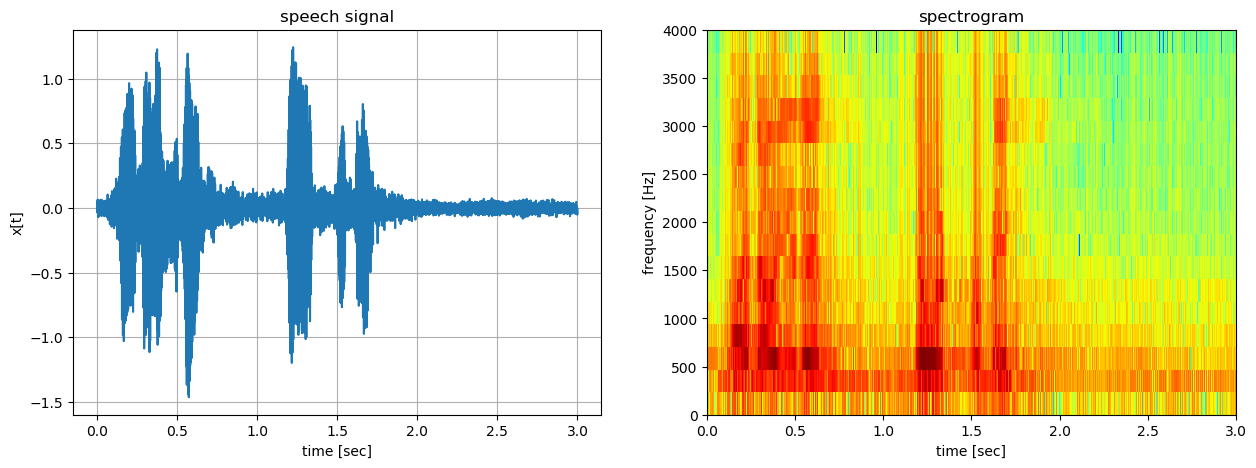

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, buffer_size, buffer_size-step_size, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Visualize warped data

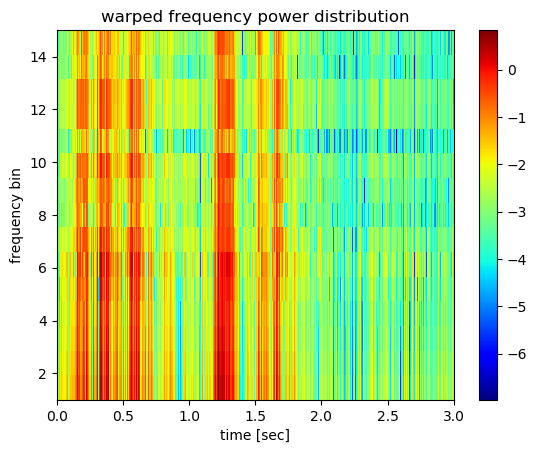

In [5]:
# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize memory vector of taps, Y, with zeros
Y = zeros(nr_taps_warped*2,1)

# initialize memory struct for filter taps and spectrum coefficients
mem_taps = Array{Array{Float64,1}}(undef, len(buf, step_size))
mem_spec = Array{Complex{Float64},2}(undef, len(buf, step_size), nr_taps_warped)

# get update matrices as defined in thesis
W, U, S = allpass_update_matrix_segment(nr_taps_warped, buffer_size, z_pole)
W = W + 1e-8I
# loop through time-domain signal
for k = 1:len(buf, step_size)
    
    # update memory vector of taps
    Y = W*Y + U*buf.buffer_s
    
    # fetch taps
    mem_taps[k] = simplify(S*Y)

    # calculate windowed FFT of taps
    mem_spec[k,:] = FFTW.fft(window(nr_taps_warped).*mem_taps[k])
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
if nr_taps_warped%2 == 0
    mem_spec = hcat(mem_spec[:, 2:Int(nr_taps_warped/2)])
else
    mem_spec = mem_spec[:, 2:Int(ceil(nr_taps_warped/2))]
end

# calculate real and imaginary parts of remaining frequency components
mem_spec_real = real(mem_spec)
mem_spec_imag = imag(mem_spec)
mem_spec_all = hcat(mem_spec_real, mem_spec_imag)
mem_spec_mag = log10.((mem_spec_all[:,1:length(freq)].^2 + mem_spec_all[:,length(freq)+1:end].^2))

# output signal
filter_output = [mem_taps[k][end] for k = 1:length(mem_taps)]

# plot warped spectrogram
plt.imshow(mem_spec_mag', aspect="auto", cmap="jet", origin="upper", extent=[t[1], t[end], 1, length(freq)]), plt.xlabel("time [sec]"), plt.ylabel("frequency bin"), plt.title("warped frequency power distribution")
plt.colorbar();

## Specify generative model

In [6]:
# create factor graph
fg = FactorGraph()

# specify process noise
@RV w ~ GaussianMeanVariance(zeros(2*length(freq)), σ_process^2*Ic(2*length(freq)))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), σ_observation_fs^2*Ic(buffer_size))

# specify previous hidden state (spectral components)
@RV s_min ~ GaussianMeanVariance(placeholder(:μ_s_min, dims = (2*length(freq),)),
                                 placeholder(:Σ_s_min, dims = (2*length(freq), 2*length(freq))))

# specify previous hidden state (warped filter bank)
@RV Y_min ~ GaussianMeanVariance(placeholder(:μ_Y_min, dims = (2*nr_taps_warped,)),
                                 placeholder(:Σ_Y_min, dims = (2*nr_taps_warped, 2*nr_taps_warped)))

# specify new hidden state
@RV s = s_min + w

# specify Fourier matrix
@RV iCS

# create variable for 'true' observations
@RV x

# update rule for hidden states
@RV Y = W*Y_min + U*x

# combine S and C to prevent posdef error :) (if order changes, ie. Y = iSCs, Y will have duplicate entries due to inverse of S)
Multiplication(s, Y, iCS)

# specify output variable
@RV y = x + v

# create placeholder for fourier matrix
placeholder(iCS, :iCS, dims = (2*length(freq), buffer_size))

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
# ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1167707607093779568 -->
 1167707607093779568 
 
 clamp_6 
 
<!-- 16070030839177008539 -->
 16070030839177008539 
 
 𝒩 
 gaussianmeanvariance_4 
 
<!-- 6214412577090715514 -->
 6214412577090715514 
 
 placeholder_μ_Y_min 
 
<!-- 16070030839177008539--6214412577090715514 -->
 16070030839177008539--6214412577090715514 
 
 μ_Y_min 
 1 out 
 2 m 
 
<!-- 8817135261150587961 -->
 8817135261150587961 
 
 placeholder_Σ_Y_min 
 
<!-- 16070030839177008539--8817135261150587961 -->
 16070030839177008539--8817135261150587961 
 
 Σ_Y_min 
 1 out 
 3 v 
 
<!-- 12344869587895169016 -->
 12344869587895169016 
 
 clamp_1 
 
<!-- 8543981991863815714 -->
 8543981991863815714 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 8543981991863815714--12344869587895169016 -->
 8543981991863815714--12344869587895169016 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 8109292047571671611 -->
 8109292047571671611 
 
 clamp_2 
 
<!-- 8543981991863815714--8109292047571671611 -->
 8543981991863815714--8109292047571671611 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 14650107763760954930 -->
 14650107763760954930 
 
 × 
 multiplication_1 
 
<!-- 14650107763760954930--16070030839177008539 -->
 14650107763760954930--16070030839177008539 
 
 Y_min 
 1 out 
 2 in1 
 
<!-- 12350773776354057094 -->
 12350773776354057094 
 
 clamp_5 
 
<!-- 14650107763760954930--12350773776354057094 -->
 14650107763760954930--12350773776354057094 
 
 clamp_5 
 1 out 
 3 a 
 
<!-- 3277998666861331723 -->
 3277998666861331723 
 
 × 
 multiplication_2 
 
<!-- 3277998666861331723--1167707607093779568 -->
 3277998666861331723--1167707607093779568 
 
 clamp_6 
 1 out 
 3 a 
 
<!-- 11280865214264052278 -->
 11280865214264052278 
 
 placeholder_Σ_s_min 
 
<!-- 16418652177490352664 -->
 16418652177490352664 
 
 clamp_4 
 
<!-- 5798657810190394076 -->
 5798657810190394076 
 
 + 
 addition_3 
 
<!-- 5798657810190394076--3277998666861331723 -->
 5798657810190394076--3277998666861331723 
 
 x 
 2 in1 
 2 in1 
 
<!-- 5764747146970752163 -->
 5764747146970752163 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 5798657810190394076--5764747146970752163 -->
 5798657810190394076--5764747146970752163 
 
 v 
 1 out 
 3 in2 
 
<!-- 6239700666217739920 -->
 6239700666217739920 
 
 × 
 multiplication_3 
 
<!-- 4568561203752416223 -->
 4568561203752416223 
 
 + 
 addition_2 
 
<!-- 6239700666217739920--4568561203752416223 -->
 6239700666217739920--4568561203752416223 
 
 Y 
 1 out 
 2 in1 
 
<!-- 6245316000637689122 -->
 6245316000637689122 
 
 + 
 addition_1 
 
<!-- 6239700666217739920--6245316000637689122 -->
 6239700666217739920--6245316000637689122 
 
 s 
 1 out 
 1 out 
 
<!-- 4568561203752416223--14650107763760954930 -->
 4568561203752416223--14650107763760954930 
 
 variable_2 
 1 out 
 2 in1 
 
<!-- 4568561203752416223--3277998666861331723 -->
 4568561203752416223--3277998666861331723 
 
 variable_3 
 1 out 
 3 in2 
 
<!-- 6245316000637689122--8543981991863815714 -->
 6245316000637689122--8543981991863815714 
 
 w 
 1 out 
 3 in2 
 
<!-- 1629276500311758495 -->
 1629276500311758495 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 6245316000637689122--1629276500311758495 -->
 6245316000637689122--1629276500311758495 
 
 s_min 
 1 out 
 2 in1 
 
<!-- 9636096619265985567 -->
 9636096619265985567 
 
 placeholder_y 
 
<!-- 9636096619265985567--5798657810190394076 -->
 9636096619265985567--5798657810190394076 
 
 y 
 1 out 
 1 out 
 
<!-- 17143863498168765565 -->
 17143863498168765565 
 
 clamp_3 
 
<!-- 355319088770957503 -->
 355319088770957503 
 
 placeholder_μ_s_min 
 
<!-

In [7]:
# create algorithm
algo = compatibility_fix(sumProductAlgorithm([s, x, Y]))

# evaluate algorithm
eval(Meta.parse(algo))
# println(algo)
;

## Perform inference

In [8]:
messages=Array{Message}(undef, 13)
data = Dict()
marginals = Dict()

# set priors 
μ_s_min = randn(2*length(freq))
Σ_s_min = 1*Ic(2*length(freq))
μ_Y_min = randn(2*nr_taps_warped)
Σ_Y_min = 1*Ic(2*nr_taps_warped)

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Array{Float64,1}[]
Σ_x = Array{Float64,2}[]
μ_s = Array{Float64,1}[]
Σ_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # fill data dictionary
    data[:μ_s_min] = μ_s_min
    data[:Σ_s_min] = Σ_s_min
    data[:μ_Y_min] = μ_Y_min
    data[:Σ_Y_min] = Σ_Y_min
    data[:y] = buf.buffer_s
    data[:iCS] = pinv(calc_C(freq, buf.buffer_t))*S
    
    # infer parameters
    step!(data, marginals, messages)

    # estimate prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[13].dist))
    push!(Σ_x, ForneyLab.unsafeCov(messages[13].dist))
    
    # save marginal of s
    push!(μ_s, ForneyLab.unsafeMean(marginals[:s]))
    push!(Σ_s, ForneyLab.unsafeCov(marginals[:s]))
    
    # update hidden states
    μ_s_min = ForneyLab.unsafeMean(marginals[:s])
    Σ_s_min = ForneyLab.unsafeCov(marginals[:s])
    μ_Y_min = ForneyLab.unsafeMean(marginals[:Y])
    Σ_Y_min = ForneyLab.unsafeCov(marginals[:Y])
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:12


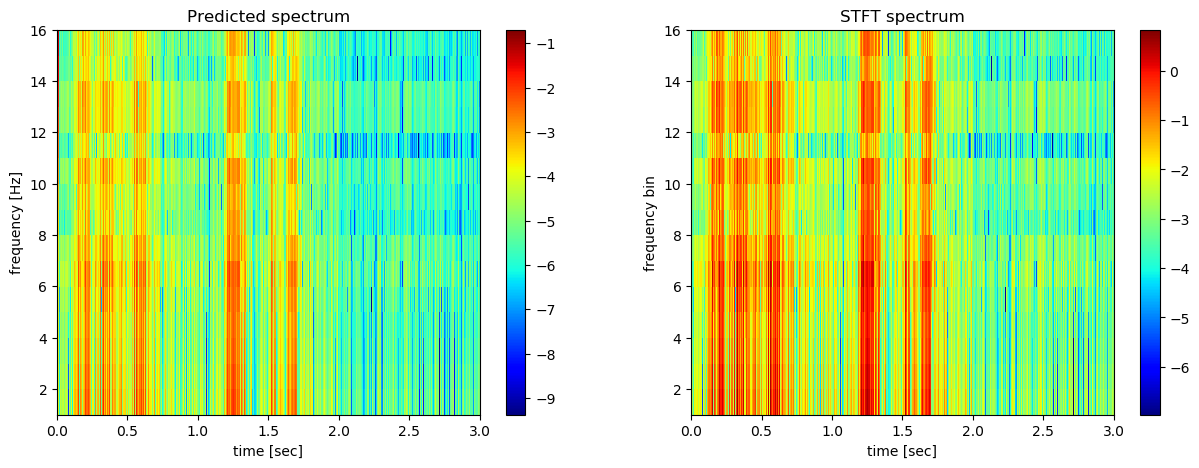

In [9]:
# convert μ_x to a 1d array
μ_x_pred = expand(reverse(hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="upper",
                   extent=[minimum(t), maximum(t), 1, Int(floor(nr_taps_warped/2))])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
cmp = ax[2].imshow(mem_spec_mag', aspect="auto", cmap="jet", origin="upper", extent=[t[1], t[end], 1, Int(floor(nr_taps_warped/2))]); plt.xlabel("time [sec]"), plt.ylabel("frequency bin"), plt.title("warped frequency power distribution")
fig.colorbar(cmp, ax=ax[2])

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

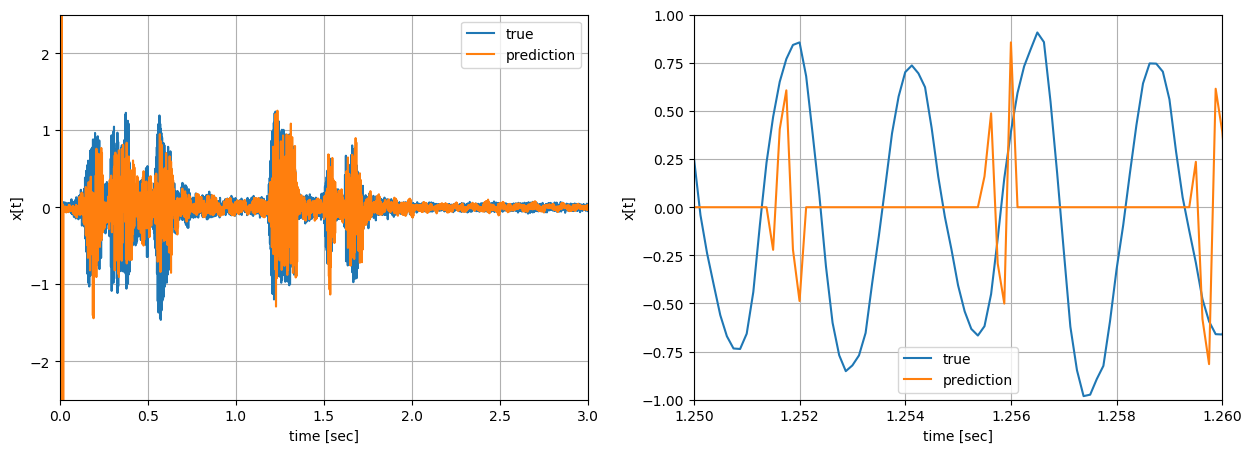

In [10]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred)], μ_x_pred, label="prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred)], μ_x_pred, label="prediction")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-2.5, 2.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.25,1.26), ax[2].set_ylim(-1, 1), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, μ_x_pred, fs=fs_desired)
;

## Performance metrics

In [11]:
MSE = 1/length(μ_x_pred) * sum(abs.(μ_x_pred - x_time[1:length(μ_x_pred)]).^2)

85.22562419101577

In [12]:
MAE = 1/length(μ_x_pred) * sum(μ_x_pred - x_time[1:length(μ_x_pred)])

-0.0559946058883227

In [13]:
using Distributions
logBME = Float64[]
for k = 1:length(μ_x)
    try 
        push!(logBME, logpdf(Distributions.MvNormal(μ_x[k], Matrix(Hermitian(Σ_x[k]))), x_time[(k-1)*32+1:k*32]))
    catch
    end
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 749       mean:-453.03257479832513